In [1]:
# Load dataset
!gdown -- https://drive.google.com/uc?id=1CtpfMnFoTkTtB9ZwfUQOpwn06ZorIQIx
!gdown -- https://drive.google.com/uc?id=1R9sQba9EIm7pW5iI6Dm2ol8xMkEchIFU # train_mspc
!gdown -- https://drive.google.com/uc?id=1xkh2-Ob2_8u3bYpWjK0DEZdbfwgag2yz # train_labels
!gdown -- https://drive.google.com/uc?id=1otaWZkLqvVCcThN91_V1Ev8sWO6lb9O2 # val_mspc
!gdown -- https://drive.google.com/uc?id=1RionvnVD7T4IiSUP7z7-xy7g9eQ1XSNx # val_labels
!gdown -- https://drive.google.com/uc?id=1rWIO9eUpOJE_O667ZRew3JoTtBhaDOUU # test_mspc

Downloading...
From (original): https://drive.google.com/uc?id=1CtpfMnFoTkTtB9ZwfUQOpwn06ZorIQIx
From (redirected): https://drive.google.com/uc?id=1CtpfMnFoTkTtB9ZwfUQOpwn06ZorIQIx&confirm=t&uuid=c8c8cc65-7655-45ca-804a-e59d4c32ec16
To: /content/fake_audio_dataset.zip
100% 3.31G/3.31G [01:07<00:00, 49.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1R9sQba9EIm7pW5iI6Dm2ol8xMkEchIFU
From (redirected): https://drive.google.com/uc?id=1R9sQba9EIm7pW5iI6Dm2ol8xMkEchIFU&confirm=t&uuid=9d222e88-7dd1-4e43-8e59-343e6572b100
To: /content/train_mspc.zip
100% 1.63G/1.63G [01:12<00:00, 22.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xkh2-Ob2_8u3bYpWjK0DEZdbfwgag2yz
To: /content/train_mspc_labels.zip
100% 12.0M/12.0M [00:00<00:00, 26.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1otaWZkLqvVCcThN91_V1Ev8sWO6lb9O2
From (redirected): https://drive.google.com/uc?id=1otaWZkLqvVCcThN91_V1Ev8sWO6lb9O2&confirm=t&uuid=40521adc-a8f9-47d4-b412-d58f40

In [3]:
!unzip -qq '/content/fake_audio_dataset.zip'
!unzip -qq '/content/train_mspc.zip'
!unzip -qq '/content/train_mspc_labels.zip'
!unzip -qq '/content/val_mspc.zip'
!unzip -qq '/content/val_mspc_labels.zip'
!unzip -qq '/content/test_mspc.zip'

In [4]:
import librosa

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random


from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
from torchvision.transforms.functional import to_pil_image

import torch
import os
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
class Config:
    SR = 32000
    N_MFCC = 128
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 64
    N_EPOCHS = 10
    LR = 3e-3
    # Others
    SEED = 42

CONFIG = Config()

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

In [7]:
pip install natsort

In [9]:
import natsort

# Specify the folder path
train_mfcc_path = '/content/train_mspc'
train_labels_path = '/content/train_labels'
val_mfcc_path = '/content/val_mspc'
val_labels_path = '/content/val_labels'
test_mfcc_path = '/content/test_mspc'


# Get list of files in the folder
train_mfcc = natsort.natsorted(os.listdir(train_mfcc_path))
train_labels = natsort.natsorted(os.listdir(train_labels_path))
val_mfcc = natsort.natsorted(os.listdir(val_mfcc_path))
val_labels = natsort.natsorted(os.listdir(val_labels_path))
test_mfcc = natsort.natsorted(os.listdir(test_mfcc_path))


In [13]:
mfcc_list = []
train_mfcc_path = '/content/train_mspc'

for file in train_mfcc:
  file_path = os.path.join(train_mfcc_path, file)
  mfcc = np.load(file_path)
  mfcc_list.append(mfcc)

train_mfcc = mfcc_list


In [14]:
mfcc_list = []
val_mfcc_path = '/content/val_mspc'

for file in val_mfcc:
  file_path = os.path.join(val_mfcc_path, file)
  mfcc = np.load(file_path)
  mfcc_list.append(mfcc)

val_mfcc = mfcc_list


In [15]:
mfcc_list = []
test_mfcc_path = '/content/test_mspc'

for file in test_mfcc:
  file_path = os.path.join(test_mfcc_path, file)
  mfcc = np.load(file_path)
  mfcc_list.append(mfcc)

test_mfcc = mfcc_list

In [16]:
train_label_list = []
train_label_path = '/content/train_labels'

for file in train_labels:
  file_path = os.path.join(train_label_path, file)
  label = np.load(file_path)
  train_label_list.append(label)

train_labels = train_label_list

In [17]:
import numpy as np
from skimage.transform import resize

# Resize each MFCC array
resized_train_mfcc = []
for mfcc in train_mfcc:
    if isinstance(mfcc, np.ndarray):
        resized_mfcc = resize(mfcc, (128, 128, 1), preserve_range=True)
        resized_train_mfcc.append(resized_mfcc)
    else:
        resized_train_mfcc.append(mfcc)  # Keep non-array elements as they are

# Update train_mfcc with resized arrays
train_mfcc = resized_train_mfcc

In [23]:
val_label_list = []
val_label_path = '/content/val_labels'

for file in val_labels:
  file_path = os.path.join(val_label_path, file)
  label = np.load(file_path)
  val_label_list.append(label)

val_labels = val_label_list

In [24]:
# Resize each MFCC array
resized_val_mfcc = []
for mfcc in val_mfcc:
    if isinstance(mfcc, np.ndarray):

        resized_mfcc = resize(mfcc, (128, 128, 1), preserve_range=True)
        resized_val_mfcc.append(resized_mfcc)
    else:
        resized_val_mfcc.append(mfcc)  # Keep non-array elements as they are

# Update train_mfcc with resized arrays
val_mfcc = resized_val_mfcc

In [25]:
# Resize each MFCC array
resized_test_mfcc = []
for mfcc in test_mfcc:
    if isinstance(mfcc, np.ndarray):
        resized_mfcc = resize(mfcc, (128, 128, 1), preserve_range=True)
        resized_test_mfcc.append(resized_mfcc)
    else:
        resized_test_mfcc.append(mfcc)  # Keep non-array elements as they are

# Update train_mfcc with resized arrays
test_mfcc = resized_test_mfcc

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, models
from tensorflow import keras
model = models.Sequential()

# 입력층
model.add(layers.Input(shape=(128, 128, 1)))

# 첫 번째 Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 두 번째 Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 세 번째 Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 네 번째 Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 다섯 번째 Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Fully Connected Layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))

# 출력층
model.add(layers.Dense(2, activation='sigmoid'))



# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC()])

# 모델 요약 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [27]:
train_mfcc = np.array(train_mfcc)
train_labels = np.array(train_labels)
val_mfcc = np.array(val_mfcc)
val_labels = np.array(val_labels)
test_mfcc = np.array(test_mfcc)

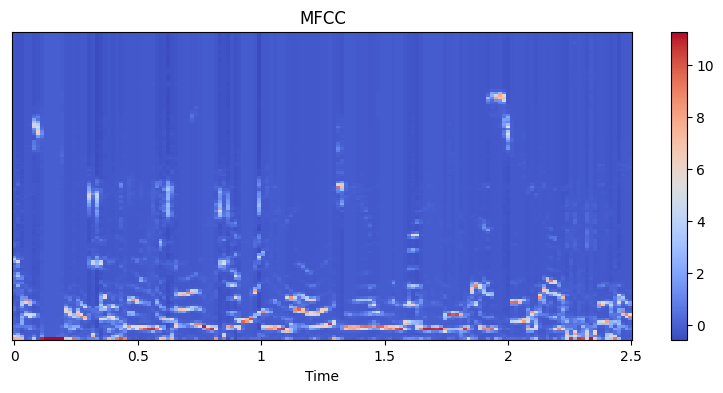

In [33]:
import matplotlib.pyplot as plt

# MFCC
mfcc = mfcc_list[4]

# MFCC 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=CONFIG.SR, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

In [34]:
model.fit(train_mfcc, train_labels, epochs=CONFIG.N_EPOCHS, batch_size = CONFIG.BATCH_SIZE, validation_data=(val_mfcc, val_labels))

Epoch 1/10
693/693 [==============================] - 31s 33ms/step - loss: 0.2448 - auc: 0.9634 - val_loss: 0.1579 - val_auc: 0.9843
Epoch 2/10
693/693 [==============================] - 20s 28ms/step - loss: 0.1103 - auc: 0.9921 - val_loss: 0.0961 - val_auc: 0.9942
Epoch 3/10
693/693 [==============================] - 20s 29ms/step - loss: 0.0668 - auc: 0.9969 - val_loss: 0.1537 - val_auc: 0.9863
Epoch 4/10
693/693 [==============================] - 20s 29ms/step - loss: 0.0472 - auc: 0.9982 - val_loss: 0.0605 - val_auc: 0.9969
Epoch 5/10
693/693 [==============================] - 20s 29ms/step - loss: 0.0341 - auc: 0.9989 - val_loss: 0.0556 - val_auc: 0.9971
Epoch 6/10
693/693 [==============================] - 20s 29ms/step - loss: 0.0276 - auc: 0.9993 - val_loss: 0.0591 - val_auc: 0.9964
Epoch 7/10
693/693 [==============================] - 20s 29ms/step - loss: 0.0230 - auc: 0.9994 - val_loss: 0.0787 - val_auc: 0.9946
Epoch 8/10
693/693 [==============================] - 20s 29ms

In [35]:
y_pred = model.predict(test_mfcc)

1563/1563 [==============================] - 7s 4ms/step


In [40]:
submit = pd.read_csv('./sample_submission.csv')
submit.iloc[:, 1:] = y_pred
submit.head(20)

,id,fake,real
0,TEST_00000,3.836535e-08,1.000000
1,TEST_00001,8.506014e-08,1.000000
2,TEST_00002,3.782793e-09,1.000000
3,TEST_00003,1.398954e-03,0.996804
4,TEST_00004,3.458729e-04,0.999373
5,TEST_00005,1.118441e-12,1.000000
6,TEST_00006,1.369598e-06,0.999998
7,TEST_00007,2.429551e-08,1.000000
8,TEST_00008,7.057511e-06,0.999987
9,TEST_00009,1.537845e-02,0.976203


In [37]:
submit.to_csv('./baseline_submit.csv', index=False)

In [38]:
submit.head(50)

,id,fake,real
0,TEST_00000,3.836535e-08,1.000000
1,TEST_00001,8.506014e-08,1.000000
2,TEST_00002,3.782793e-09,1.000000
3,TEST_00003,1.398954e-03,0.996804
4,TEST_00004,3.458729e-04,0.999373
5,TEST_00005,1.118441e-12,1.000000
6,TEST_00006,1.369598e-06,0.999998
7,TEST_00007,2.429551e-08,1.000000
8,TEST_00008,7.057511e-06,0.999987
9,TEST_00009,1.537845e-02,0.976203
